In this project, we'll be predicting the price of diamonds using linear regression. We'll start by importing the relevant packages and data.

In [1]:
%pylab inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


DIAMONDS_FILENAME = "diamonds.csv"
NEW_DIAMONDS_FILENAME = "new-diamonds.csv"

diamonds = pd.read_csv(DIAMONDS_FILENAME)
del diamonds["Unnamed: 0"]
new_diamonds = pd.read_csv(NEW_DIAMONDS_FILENAME)
del new_diamonds["Unnamed: 0"]

Populating the interactive namespace from numpy and matplotlib


Let's have a quick gander at the data.

In [2]:
diamonds.head()

,carat,cut,cut_ord,color,clarity,clarity_ord,price
0,0.51,Premium,4,F,VS1,4,1749
1,2.25,Fair,1,G,I1,1,7069
2,0.70,Very Good,3,E,VS2,5,2757
3,0.47,Good,2,F,VS1,4,1243
4,0.30,Ideal,5,G,VVS1,7,789


In [3]:
new_diamonds.head()

,carat,cut,cut_ord,color,clarity,clarity_ord
0,1.22,Premium,4,G,SI1,3
1,1.01,Good,2,G,VS2,5
2,0.71,Very Good,3,I,VS2,5
3,1.01,Ideal,5,D,SI2,2
4,0.27,Ideal,5,H,VVS2,6


Aha! So looks like we have four pieces of information about `diamonds`. We know how heavy the diamond is (the carat column), we know how good the cut is, and we know the clarity. Those last two have two columns each, one with a human readable version, and one with a numerical (ordinal) version, which uses a numeric scale to capture the same information.

For the `new_diamonds` data, we have all the same information, except the price, which is what we're trying to find out! Let's get to it! We'll use a linear regression to predict price from carat, cut, and clarity.

In [4]:
X = diamonds[['carat', 'cut_ord', 'clarity_ord']]
y = diamonds['price']
linear_regression = LinearRegression()
linear_regression.fit(X, y)

print linear_regression.intercept_
print linear_regression.coef_

-5255.22314648
[ 8363.41665765   160.37858283   457.80181294]


/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Our regression has created a line of best fit, whereby price can be estimated as follows:

$$price = -5255 + 8363 \times carat + 160 \times cut + 458 \times clarity.$$

This is close to, but not exactly the same as the equation we were provided with at the start of this project:

$$price = -5269 + 8413 \times carat + 158.1 \times cut + 454 \times clarity.$$

I wonder where the distincation lies. Anyway, using the provided equation, if given two otherwise identical diamonds, the heavier diamond would be expected to cost $8,413 more per karat than the lighter diamond.

# Understanding the Model

If you wished to purchase a diamond with the following characteristics;

$$
\begin{aligned}
carat &= 1.5\\
cut &= 3\\
clarity &= 5,
\end{aligned}
$$

Then you should expect to pay

$$
\begin{aligned}
price &= -5269 + 8413 \times 1.5 + 158.1 \times 3 + 454 \times 5\\
price &= \$10,094.80
\end{aligned}
$$

Or, using our linear regression:

In [5]:
linear_regression.predict([[1.5, 3, 5]])[0]

10060.046653174173

# Visualize the Data

Let's now predict the prices for all of the `new_diamonds`, and overlay their prices on a plot of the prices of the known `diamonds`.

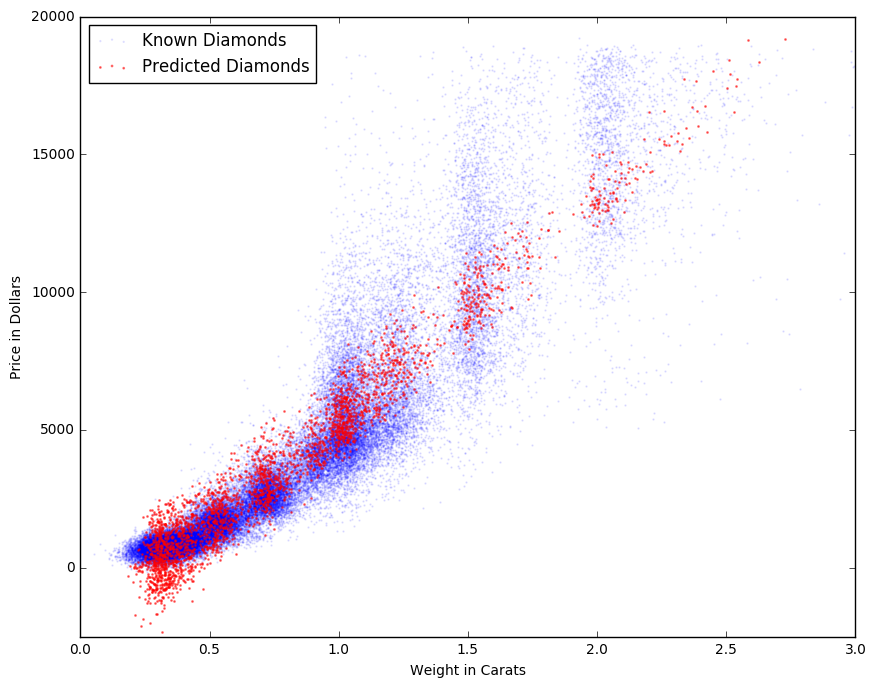

In [6]:
new_diamonds['price'] = linear_regression.predict(
    new_diamonds[['carat', 'cut_ord', 'clarity_ord']]
)

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
ax.set_autoscale_on(False)
plt.xlim([0,3])
plt.ylim([-2500, 20000])
plt.scatter(rand_jitter(diamonds['carat']), 
            rand_jitter(diamonds['price']), 
            color="Blue", alpha=.1, s=.5, label="Known Diamonds")
plt.scatter(rand_jitter(new_diamonds['carat']), 
            rand_jitter(new_diamonds['price']), 
            color="Red", alpha=.5, s=1, label="Predicted Diamonds")
plt.xlabel('Weight in Carats')
plt.ylabel('Price in Dollars')
ax.legend(loc=2)
plt.show()

Uh oh. This plot gives me a lot of reasons to be heasitant about using this model to predict diamonds prices. First, it is predicting negative prices for some diamonds, which doesn't seem right. It does alright for stones between .5 and 1.0 karats, but as stones get heavier than that, their prices spread waaaay out. It seems like there are 1.5 karat stones that sell from anywhere between 3k and 20k, and our linear model isn't reflecting that range at all.

Side note, it looks like around 20k is the hard limit on price for diamonds in our data set. I wonder why that is.


# Make a Prediction

Let's determine what we should bid for a 1.5 karat diamond of Very Good cut, and VS2 clarity. Recall that our regression suggested $10,094.80. However, we don't really trust our regression. Let's see if we can do a little better. Let's start by analyzing the prices of diamonds of the same cut and clarity, and approximatly the same weight.

In [7]:
def analyze_prices(diamonds, min_weight, max_weight, cut, clarity):
    right_cut = diamonds.loc[
        diamonds['cut_ord'] == cut
    ]
    right_clarity = right_cut.loc[
        right_cut['clarity_ord'] == clarity
    ]
    right_min_weight = right_clarity.loc[
        right_clarity['carat'] >= min_weight
    ]
    diamonds_of_interest = right_min_weight.loc[
        right_min_weight['carat'] <= max_weight
    ]
    print diamonds_of_interest['price'].\
        describe(percentiles=[.05, .25, .75, .95])
    
analyze_prices(diamonds, 1.5, 1.75, 3, 5)

count      209.000000
mean     11983.143541
std       2709.148967
min       7109.000000
5%        7504.000000
25%      10023.000000
50%      12038.000000
75%      13799.000000
95%      16737.000000
max      18691.000000
Name: price, dtype: float64


Looks like diamonds of the same properties as the one we wish to buy range in price from \$7,109 to \$18,691. Wow! We clearly don't have enough data here to make accurate predictions about diamond prices. In this case, I'd suggest that (lacking the ability to do anything like consult a jewler), we should bid at the 5th percentile. That way we have a 95% chance of getting our money's worth. In addition, we should retain an appraizer at the earliest opportunity.